In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/smote_analysis

In [4]:
# 데이터셋 import. 신용카드 부정사용 관련 데이터. 

# https://www.kaggle.com/mlg-ulb/creditcardfraud

df = pd.read_csv('./creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()
#이중 50,000개 데이터만 활용
df=df[:50000]

### 전형적인 imbalanced dataset : 총 50,000 중 부정사용 case는 148개

In [7]:
print('Fraud :',len(df.Time[df.Class==1]))
print('Non-Fraud :',len(df.Time[df.Class==0]))


Fraud : 148
Non-Fraud : 49852


In [8]:
# Timestamp는 분석목적과 관련 없다고 판단되므로 제외. 

df.drop(['Time'], axis=1, inplace=True)

In [9]:
# 추후에 반복적으로 사용될 confusion matrix를 보이는 함수를 미리 정의

from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.5f}'.format(recall),'\nPrecision={0:0.5f}'.format(precision))
    print('F1={0:0.5f}'.format(F1))

In [1]:
# 데이터셋 준비. test_size는 30%

from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 77)
print(len(X_train))
print(len(X_test))

NameError: name 'df' is not defined

In [11]:
# 우리가 각 샘플링 기법들의 성능 비교를 할 기본적 classifier는 
# RandomForest Model, Support Vector Machine, 그리고 Bagging

from sklearn.ensemble import RandomForestClassifier as RF

from sklearn import svm

from sklearn.ensemble import BaggingClassifier

Classification of original dataset RandomForest (scikit-learn)


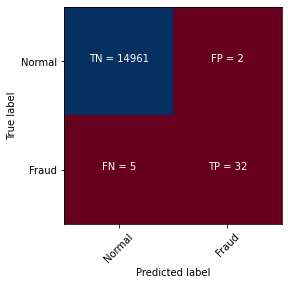

Recall=0.86486 
Precision=0.94118
F1=0.90141


In [12]:
#샘플링 기법들을 적용하지 않고 default data로 baseline을 확인
#Random Forest

pre = RF(n_jobs=-1, random_state = 42,max_features= 'sqrt', criterion = 'entropy')

pre.fit(X_train, y_train)

y_pred = pre.predict(X_test)

#Make plot
print('Classification of original dataset RandomForest (scikit-learn)')
plot_cm(pre, y_pred)

Classification of original dataset with SVM (scikit-learn)


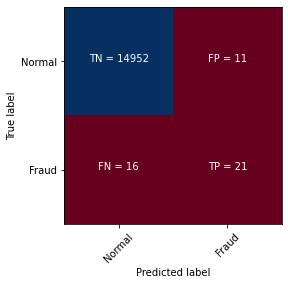

Recall=0.56757 
Precision=0.65625
F1=0.60870


In [21]:
#SVM

svm_default = svm.SVC(kernel='rbf') # RBF Kernel

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 77)

svm_default.fit(X_train, y_train)

#Make predictions
y_pred = svm_default.predict(X_test)

#Make plots
print('Classification of original dataset with SVM (scikit-learn)')
plot_cm(svm_default, y_pred)

Classification of original dataset with Bagging (scikit-learn)


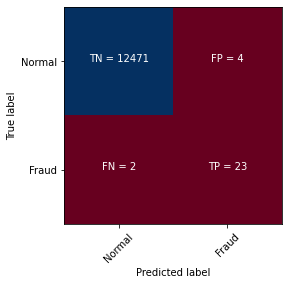

Recall=0.92000 
Precision=0.85185
F1=0.88462


In [14]:
# Bagging

bagging = BaggingClassifier(random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 77)

bagging.fit(X_train, y_train)

#Make predictions

y_pred = bagging.predict(X_test)

#Make plots
print('Classification of original dataset with Bagging (scikit-learn)')
plot_cm(bagging, y_pred)


### 신용카드 Fraud Dectection은 Precision보다 Recall이 더 중요하다!

### Recall이 낮은 것은 데이터셋의 불균형에 문제가 있다고 판단하여, UnderSampling 진행

#imbalanced-learn 설치
#!pip install -U imbalanced-learn
#OR
#!conda install -c conda-forge imbalanced-learn

Classification of original dataset with Balanced_Bagging (scikit-learn)


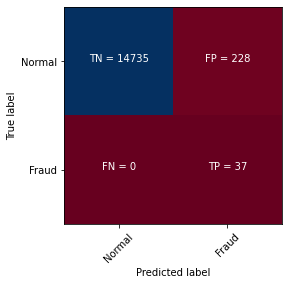

Recall=1.00000 
Precision=0.13962
F1=0.24503


In [23]:
#under-sampling 은 BalancedBagging으로 진행

from imblearn.ensemble import BalancedBaggingClassifier

from imblearn.metrics import classification_report_imbalanced

balanced_bagging = BalancedBaggingClassifier(random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 77)

balanced_bagging.fit(X_train, y_train)

#Make predictions
y_pred = balanced_bagging.predict(X_test)

#Make plots
print('Classification of original dataset with Balanced_Bagging (scikit-learn)')
plot_cm(balanced_bagging, y_pred)

### 적은 class에 맞게 undersampling 되어, 시간은 작게 걸리지만 심각하게 under-fitted
### precision이 지나치게 낮다고 판단되며, 이는 전체 학습에 동원되는 data set의 수가 작기 때문이라 판단
### BalancedBagging 이외, 다른 모델의 언더샘플링은 진행하지 않음

## RandomOver Sampling 후 Random Forest Model learning 진행

Classification of random over-sampled dataset with RandomForest


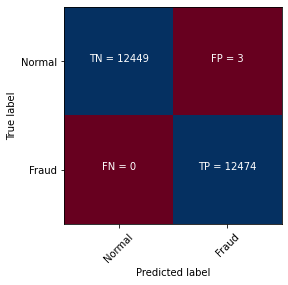

Recall=1.00000 
Precision=0.99976
F1=0.99988


In [24]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority', random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_res, y_res = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 77)

RF_oversample = RF(n_jobs=-1, random_state = 77,max_features= 'sqrt', criterion = 'entropy')

RF_oversample.fit(X_train, y_train)

#Make predictions

y_pred = RF_oversample.predict(X_test)

#Make plots
print('Classification of random over-sampled dataset with RandomForest')
plot_cm(RF_oversample, y_pred)

### 단순한 랜덤오버 샘플링만으로도 상당히 높은 score

## SMOTE 후 Random Forest Model learning 진행

Classification of SMOTE-resampled dataset with RandomForest


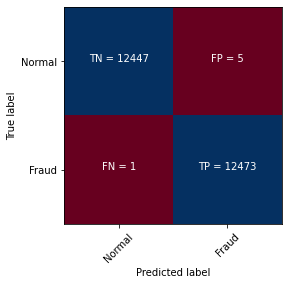

Recall=0.99992 
Precision=0.99960
F1=0.99976


In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 77)

#fit the best models so far
RF_SMOTE = RF(n_jobs=-1, random_state = 77,max_features= 'sqrt', criterion = 'entropy')

RF_SMOTE.fit(X_train, y_train)

#Make predictions
y_pred = RF_SMOTE.predict(X_test)

#Make plots
print('Classification of SMOTE-resampled dataset with RandomForest')
plot_cm(RF_SMOTE, y_pred)

## ADASYN에 의한 오버샘플링 후, Random Forest Model 학습


Classification of ADASYN-resampled dataset with RandomForest


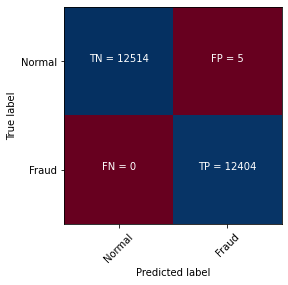

Recall=1.00000 
Precision=0.99960
F1=0.99980


In [18]:
# training data set의 크기가 거의 2배로 증가되어 시간 많이 걸림

from imblearn.over_sampling import ADASYN 
ada = ADASYN(random_state=77)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_res, y_res = ada.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 77)

#fit the best models so far
RF_ada = RF(n_jobs=-1, random_state = 77,max_features= 'sqrt', criterion = 'entropy')

RF_ada.fit(X_train, y_train)

#Make predictions
print('')
y_pred = RF_ada.predict(X_test)

#Make plots
print('Classification of ADASYN-resampled dataset with RandomForest')
plot_cm(RF_ada, y_pred)


## SMOTE에 의한 오버샘플링 후, SVM 학습

Classification of SMOTE-resampled dataset with SVM


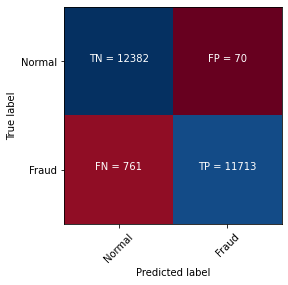

Recall=0.93899 
Precision=0.99406
F1=0.96574


In [25]:
smote = SMOTE(random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 77)

#fit the best models so far
svm_smote = svm.SVC(kernel='rbf') # RBF Kernel

svm_smote.fit(X_train, y_train)

#Make predictions
y_pred = svm_smote.predict(X_test)

#Make plots
print('Classification of SMOTE-resampled dataset with SVM')
plot_cm(svm_smote, y_pred)

In [26]:
print(len(X_train))

74778


## ADASYN에 의한 후, SVM 학습

Classification of ADASYN-resampled dataset with SVM


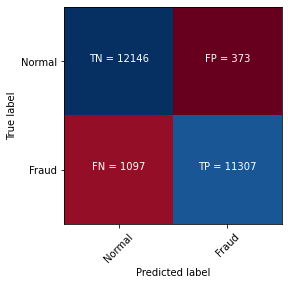

Recall=0.91156 
Precision=0.96807
F1=0.93896


In [20]:
ada = ADASYN(random_state=77)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_res, y_res = ada.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 77)

svm_adasyn = svm.SVC(kernel='rbf') # RBF Kernel

svm_adasyn.fit(X_train, y_train)

#Make predictions
y_pred = svm_adasyn.predict(X_test)

#Make plots
print('Classification of ADASYN-resampled dataset with SVM')
plot_cm(svm_adasyn, y_pred)

## 잠정결론

1. fraud detection과 같은 이상치 탐지 모델의 경우 - 오버샘플링을 하지 않을 경우 recall이 낮게 나타남
2. UnderSampling은 Recall에 비해 전체적 Precision이 극도로 낮음
3. 모델에 따라 Random Oversampling이 SMOTE과 ADASYN에 맞먹는 효과를 보임
4. 본 데이터 셋의 경우, Random Forest Model이 SVM의 경우 보다 높은 F1 score를 보임

The end